In [128]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
pd.set_option('max_columns', 120)
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error,mean_squared_error
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')
import math

In [129]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [130]:
y = train_df['SalePrice']
train_df = train_df.drop(columns='SalePrice')

In [131]:
df = train_df.append(test_df,ignore_index=True)

In [132]:
df.dtypes.value_counts()

object     43
int64      26
float64    11
dtype: int64

In [133]:
def encode(data):
    encoder = OrdinalEncoder()
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

In [134]:
def enc_imp(df):
    for i in df.columns:
        if df.dtypes[i] == 'int64':
            pass
        elif df.dtypes[i] == 'float64':
            pass
        else:
            df[i] = encode(df[i])
            
    imputer = KNNImputer(n_neighbors=2)

    null_col = df[df.columns[df.isnull().any()]].isnull()

    for i in null_col:
        df[i] = imputer.fit_transform(df[[i]].values)
    return df

In [135]:
df = enc_imp(df)

### Columns Pre-processing

In [136]:
#MSSubClass 
for i in range(len(df['MSSubClass'])):
    val = df['MSSubClass'][i]
    if val >= 20 and val <= 40:
        new_val = 1
    elif val >40 and val <= 50:
        new_val = 2
    elif val >50 and val <= 75:
        new_val = 3
    elif val >75 and val <= 90:
        new_val = 4
    elif val >90 and val <= 160:
        new_val = 5
    elif val >160 and val <= 190:
        new_value = 6
    
    df['MSSubClass'][i] = new_val

In [137]:
#OverallQual 
for i in range(len(df['OverallQual'])):
    val = df['OverallQual'][i]
    if val >= 1 and val <= 4: 
        new_val = 1 #Below Average
    elif val == 5:
        new_val = 2 # Average
    elif val >5 and val <= 9:
        new_val = 3 # Above Average
    elif val > 9:
        new_val = 4 # Awesome
    
    
    df['OverallQual'][i] = new_val

In [138]:
#MoSold
for i in range(len(df['MoSold'])):
    val = df['MoSold'][i]
    if val >= 1 and val <= 3: 
        new_val = 1 #1st quarter
    elif val > 3 and val <= 6:
        new_val = 2 # 2nd quarter
    elif val > 6 and val <= 9:
        new_val = 3 # 3rd quarter
    elif val > 9:
        new_val = 4 # 4th quarter
    
    
    df['MoSold'][i] = new_val

In [139]:
#GarageYrBlt 
def yr_cha(df,col):
    for i in range(len(df[col])):
        val = df[col][i]
        if val >= 1850 and val <= 1900:
            new_val = 1
        elif val >1900 and val <= 1950:
            new_val = 2
        elif val >1950 and val <= 2000:
            new_val = 3
        elif val >2000 and val <= 2050:
            new_val = 4
        
        df[col][i] = new_val
    
    return df[col]

df['GarageYrBlt'] = yr_cha(df,'GarageYrBlt')


In [140]:
# Removing fireplaces quality if there are no fireplaces in the house
for i in range(len(df)):
    if df['Fireplaces'][i] == 0:
        df['FireplaceQu'][i] = 0

In [141]:
df['GarageYrBlt'] = df['GarageYrBlt'].astype(int)

In [142]:
df['Bath'] = df['FullBath'] +(0.5 * df['HalfBath'] + df['BsmtFullBath']+ (0.5 * df['BsmtHalfBath'])) 
df['Total_rooms'] = df['Bath'] + df['TotRmsAbvGrd'] * df['BedroomAbvGr']

In [143]:
df['Garage_cond'] = df['GarageQual'] * df['GarageCond'] * df['GarageFinish']

In [144]:
df['Fireplace_cond'] = df['ExterQual'] * df['ExterCond']

In [145]:
df['Fireplace_cond'] = df['Fireplaces'] * df['FireplaceQu']

In [146]:
df['Bsmt_cond'] = df['BsmtQual'] * df['BsmtCond']

In [147]:
df['Bsmt_type'] = df['BsmtFinType1'] + df['BsmtFinType2']

In [148]:
df['Total_sft'] = df['1stFlrSF']+df['2ndFlrSF']+df['GrLivArea']

In [149]:
df['Overall_cond'] = df['OverallQual'] * df['OverallCond'] * df['Fence']

In [150]:
for i in range(len(df)):
    if not df['GarageCars'][i] == 0.0:
        df['GarageArea'][i] /= df['GarageCars'][i]
        df['GarageCars'][i] = 0
df['Per_car_area'] = df['GarageArea']

In [151]:
df['Heat_cond'] = df['Heating'] + df['HeatingQC']

In [152]:
df['Porch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['WoodDeckSF']

In [153]:
df['Tot_lot_area'] = df['LotFrontage'] + df['LotArea']

In [154]:
df['lot_cond'] = df['LotShape'] + df['LotConfig']

In [155]:
df['Fin_bsmt'] = df['TotalBsmtSF'] - df['BsmtUnfSF']

In [156]:
# Months house in good condition
for i in range(len(df)):
    if df['YearBuilt'][i] == df['YearRemodAdd'][i]:
        pass
    else:
        df['YearBuilt'][i] = df['YearRemodAdd'][i]
        
df['House_months'] = (abs(df['YrSold'] - df['YearBuilt']))*12 + df['MoSold']

In [157]:
# 1 for only one ext/cond type and 2 for 2nd type
def cond(col1,col2):
    cond_typ = []
    for i in range(len(df)):
        if df[col1][i] == df[col2][i]:
            cond = 1
        else:
            cond = 2
    
        cond_typ.append(cond)
    return cond_typ

df['Ext_type'] = cond('Exterior1st','Exterior2nd')
#df['H_cond_type'] = cond('Condition1','Condition2')

In [158]:
col_names=['Bath','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','TotRmsAbvGrd','BedroomAbvGr',
          'GarageQual','GarageCond','GarageFinish',
          'ExterQual','ExterCond','Fireplaces','FireplaceQu','BsmtQual','BsmtCond',
          'BsmtFinType1','BsmtFinType2','1stFlrSF','2ndFlrSF','GrLivArea',
          'OverallQual','OverallCond','Fence','GarageCars','GarageArea',
          'Heating','HeatingQC','OpenPorchSF','EnclosedPorch','WoodDeckSF',
          'LotFrontage','LotArea','LotShape','LotConfig',
          'BsmtFinSF1','TotalBsmtSF','BsmtUnfSF','YearBuilt','YearRemodAdd','YrSold','MoSold',
          'Exterior1st','Exterior2nd']


df=df.drop(columns=col_names)

In [159]:
remove_col = ['Id']
for i in df.columns:
    val = df[i].value_counts(normalize = True, dropna = False).tolist()
    if val[0] >= 0.65:
        remove_col.append(i)

df=df.drop(columns=remove_col)

In [160]:
df['Total_rooms'].value_counts(normalize=True)

20.000000    0.072970
23.500000    0.048989
23.000000    0.043165
20.500000    0.042823
17.000000    0.038712
               ...   
58.960576    0.000343
76.500000    0.000343
64.000000    0.000343
1.500000     0.000343
76.000000    0.000343
Name: Total_rooms, Length: 118, dtype: float64

In [161]:
#Rounding numbers to nearest integers
round_lst = ['Neighborhood','HouseStyle','MasVnrType','Foundation','KitchenQual','GarageType',
        'Garage_cond','Fireplace_cond','Bsmt_cond','Bsmt_type','Overall_cond','Heat_cond','lot_cond']
for i in range(len(df)):
    for l in round_lst:
        df[l][i] = int(round(df[l][i]))
    

In [162]:
df

,MSSubClass,Neighborhood,HouseStyle,MasVnrType,MasVnrArea,Foundation,KitchenQual,GarageType,GarageYrBlt,Total_rooms,Garage_cond,Fireplace_cond,Bsmt_cond,Bsmt_type,Total_sft,Overall_cond,Per_car_area,Heat_cond,Porch,Tot_lot_area,lot_cond,Fin_bsmt,House_months,Ext_type
0,3,5.0,5.0,1.0,196.0,2.0,2.0,1.0,4,27.5,16.0,0.0,6.0,7.0,3420,21.0,274.000000,1.0,61,8515.0,7.0,706.0,61,2
1,1,24.0,2.0,2.0,0.0,1.0,3.0,1.0,3,20.5,16.0,4.0,6.0,5.0,2524,34.0,230.000000,1.0,298,9680.0,5.0,978.0,374,1
2,3,5.0,5.0,1.0,162.0,2.0,2.0,1.0,4,21.5,16.0,4.0,6.0,7.0,3572,21.0,304.000000,1.0,42,11318.0,4.0,486.0,75,2
3,3,6.0,5.0,2.0,0.0,0.0,2.0,5.0,3,23.0,32.0,2.0,3.0,5.0,3434,21.0,214.000000,3.0,307,9610.0,0.0,216.0,433,2
4,3,15.0,5.0,1.0,350.0,2.0,2.0,1.0,3,39.5,16.0,4.0,6.0,7.0,4396,21.0,278.666667,1.0,276,14344.0,2.0,655.0,100,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,5,10.0,5.0,2.0,0.0,1.0,3.0,2.0,3,16.5,18.0,0.0,9.0,10.0,2184,10.0,0.000000,3.0,0,1957.0,7.0,0.0,434,1
2915,5,10.0,5.0,2.0,0.0,1.0,3.0,4.0,3,19.5,32.0,0.0,9.0,9.0,2184,7.0,286.000000,5.0,24,1915.0,7.0,252.0,434,1
2916,1,11.0,2.0,2.0,0.0,1.0,3.0,5.0,3,30.0,32.0,4.0,9.0,5.0,2448,20.0,288.000000,1.0,474,20160.0,7.0,1224.0,123,2
2917,4,11.0,6.0,2.0,0.0,2.0,3.0,2.0,3,19.5,18.0,0.0,6.0,7.0,1940,20.0,0.000000,5.0,112,10503.0,7.0,337.0,171,2


### Removing Outliers

In [163]:
for col in df.columns:
    q1 = df[col].quantile(0.25)
    median = df[col].quantile(0.50)
    q3 = df[col].quantile(0.75)
    
    iqr = q3-q1 
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    
    df[col] = np.where(df[col] < low , median,df[col])
    df[col] = np.where(df[col] > high, median,df[col])

In [164]:
df.describe()

,MSSubClass,Neighborhood,HouseStyle,MasVnrType,MasVnrArea,Foundation,KitchenQual,GarageType,GarageYrBlt,Total_rooms,Garage_cond,Fireplace_cond,Bsmt_cond,Bsmt_type,Total_sft,Overall_cond,Per_car_area,Heat_cond,Porch,Tot_lot_area,lot_cond,Fin_bsmt,House_months,Ext_type
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,2.347037,12.437136,3.026721,1.767044,60.345882,1.375128,2.557383,2.268585,3.126413,19.925475,17.399794,1.348407,7.022268,7.425831,2914.866735,19.699212,265.243281,2.559096,153.280233,9288.344190,5.003426,480.808155,284.779034,1.644399
std,1.391674,5.957992,1.912937,0.605433,101.772849,0.693709,0.542927,1.742646,0.611281,7.122192,12.655671,1.615835,1.802781,2.146110,855.898203,5.298942,43.153239,1.765517,128.707146,3176.982797,2.328708,449.442585,250.648989,0.478777
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.500000,0.000000,0.000000,2.000000,1.000000,668.000000,6.000000,132.000000,1.000000,0.000000,1491.000000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,7.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,3.000000,15.000000,2.000000,0.000000,6.000000,6.000000,2248.000000,17.000000,238.000000,1.000000,39.000000,7550.500000,4.000000,0.000000,51.500000,1.000000
50%,2.000000,12.000000,2.000000,2.000000,0.000000,1.000000,3.000000,1.000000,3.000000,20.000000,16.000000,0.000000,6.000000,7.000000,2882.000000,21.000000,262.666667,1.000000,141.000000,9519.305795,7.000000,458.000000,183.000000,2.000000
75%,3.000000,17.000000,5.000000,2.000000,102.201312,2.000000,3.000000,5.000000,4.000000,23.500000,32.000000,2.000000,9.000000,10.000000,3425.000000,21.000000,288.000000,5.000000,238.000000,11135.500000,7.000000,795.500000,517.000000,2.000000
max,5.000000,24.000000,7.000000,3.000000,408.000000,3.000000,3.000000,5.000000,4.000000,38.500000,32.000000,6.000000,9.000000,10.000000,5336.000000,30.000000,393.000000,9.000000,549.000000,17792.000000,7.000000,1972.000000,723.000000,2.000000


<AxesSubplot:xlabel='Total_rooms'>

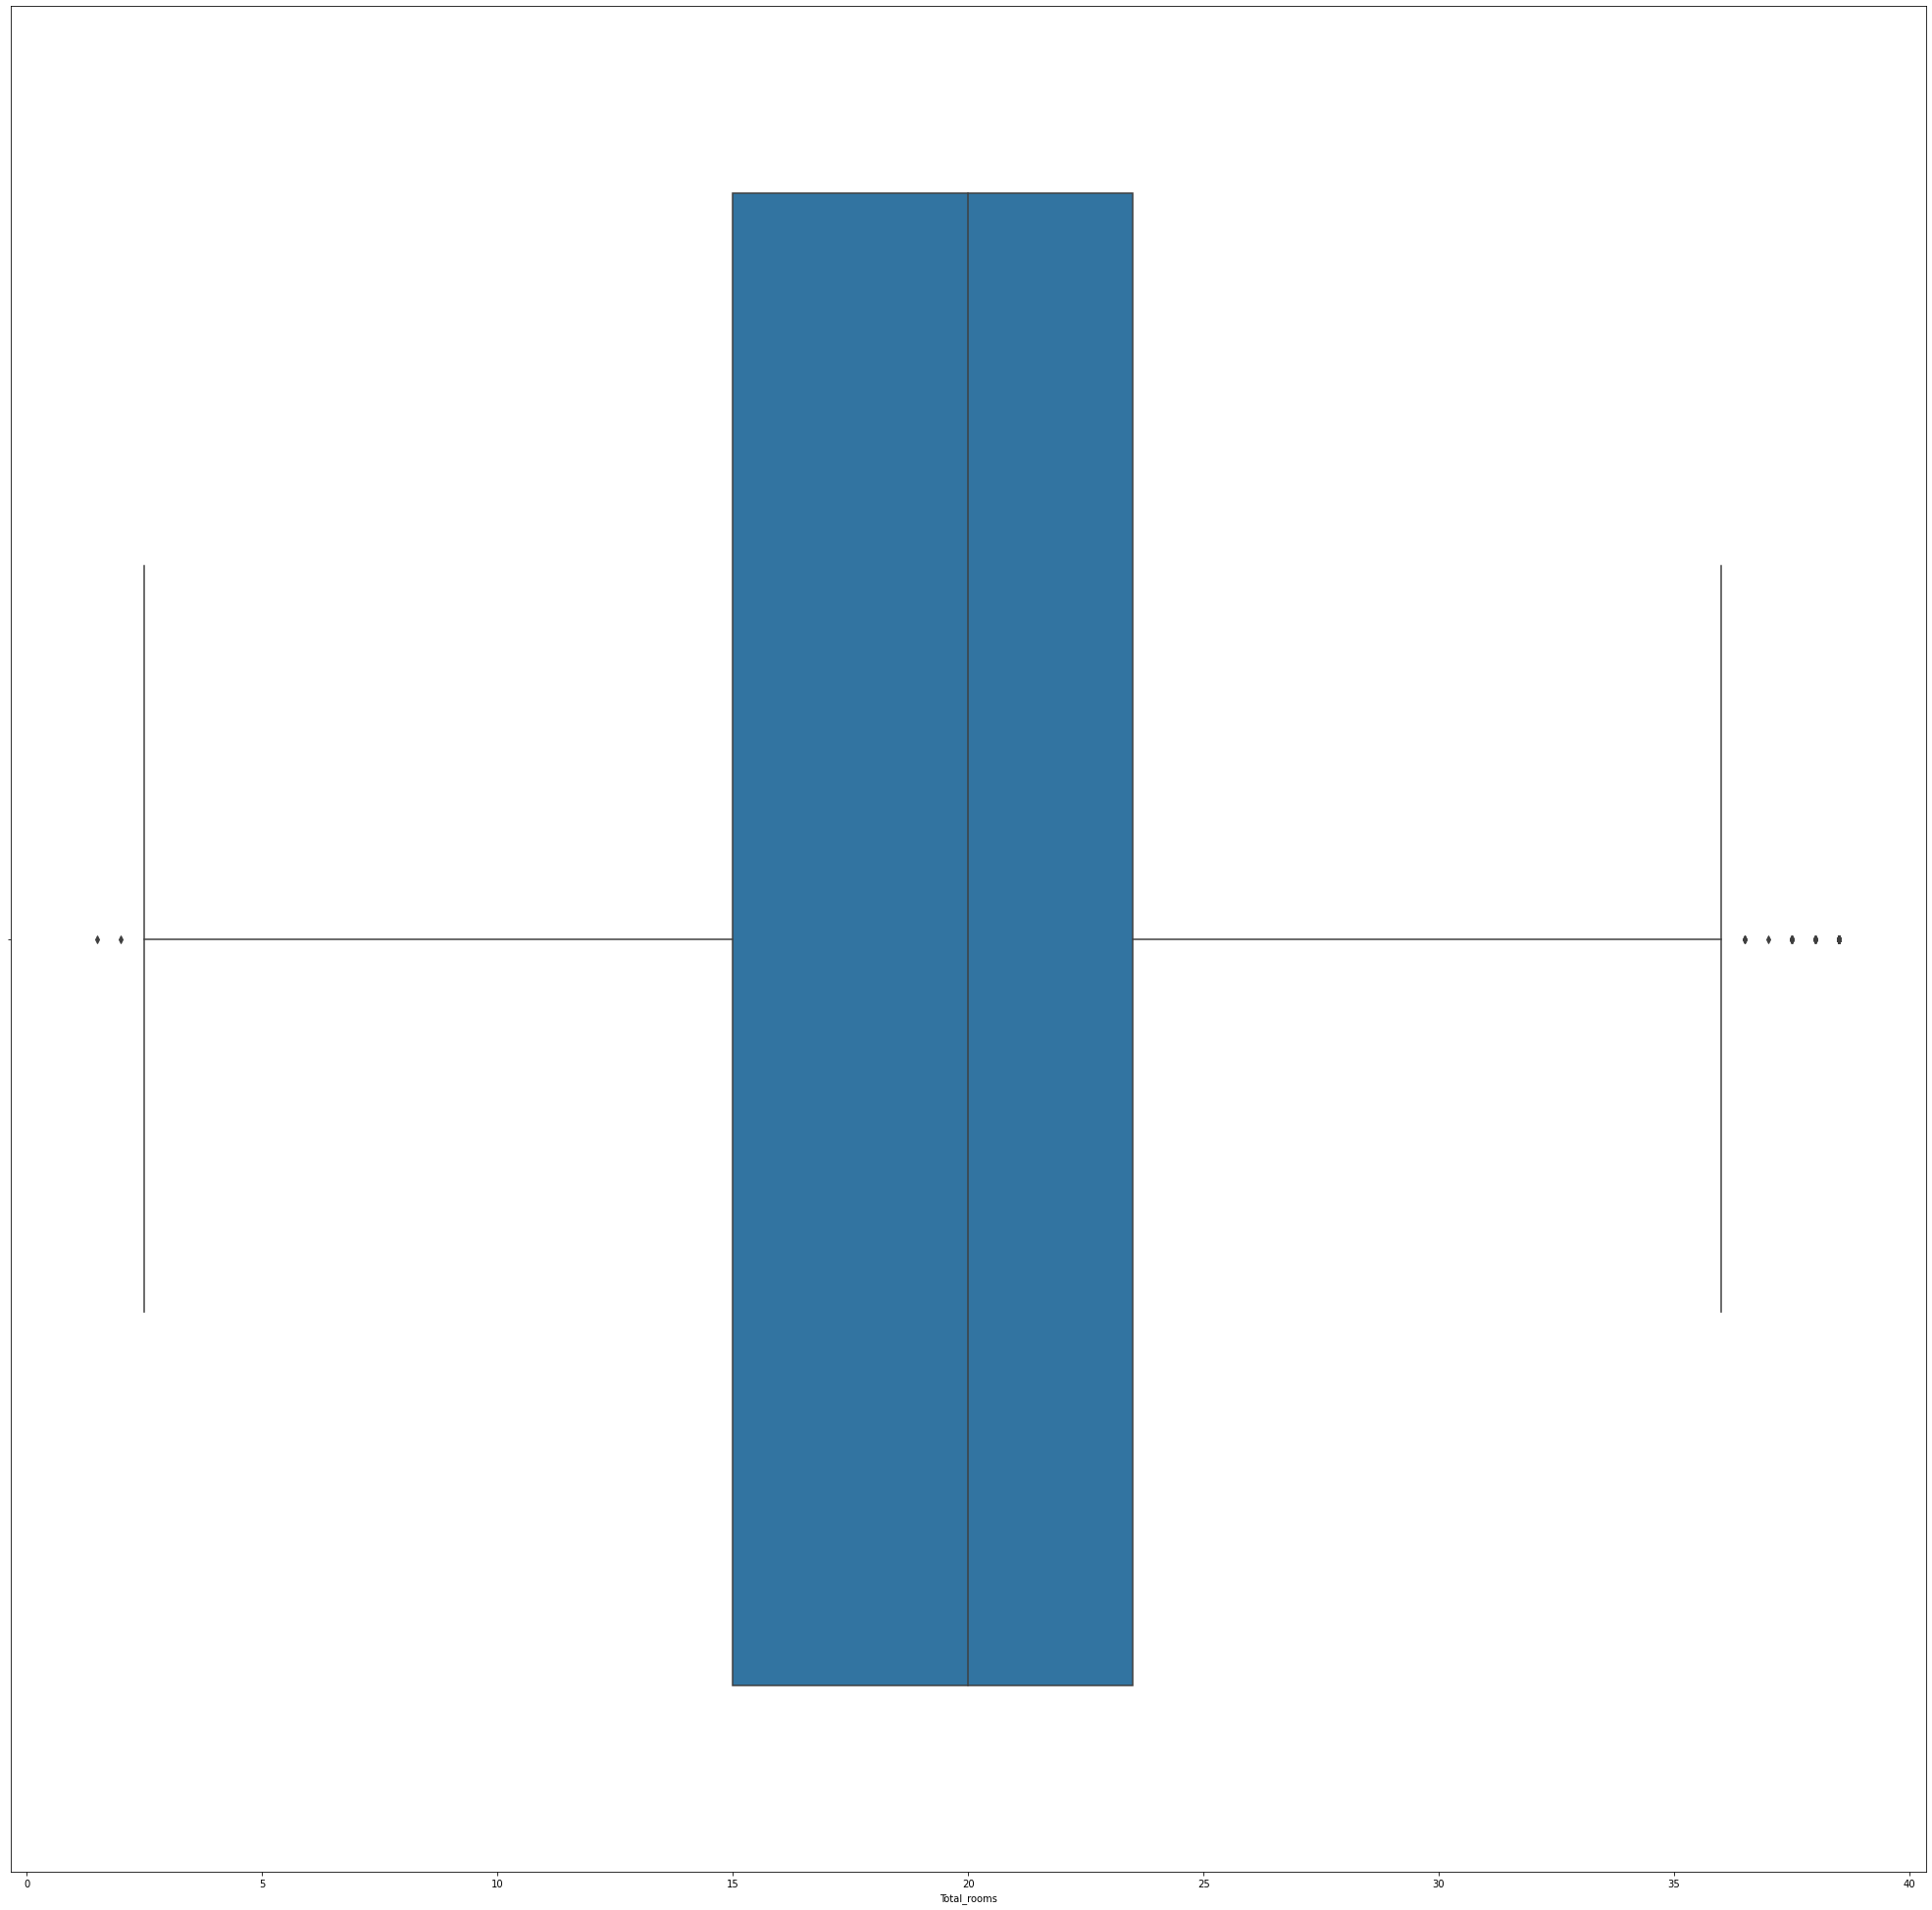

In [165]:
sns.boxplot(x=df['Total_rooms'])

### Finding Key importances

In [166]:
rfr = RandomForestRegressor(random_state=0)

In [167]:
rfr.fit(df[:1460],y)

RandomForestRegressor(random_state=0)

In [168]:
key_col ={}
imp = rfr.feature_importances_.tolist() *100
for i in range(len(df.columns)-1):
    key_col[df.columns[i]]= imp[i]
            

In [169]:
key_col

{'MSSubClass': 0.006146089751652169,
 'Neighborhood': 0.03700666034183854,
 'HouseStyle': 0.0058411607130906115,
 'MasVnrType': 0.006613171360052748,
 'MasVnrArea': 0.008476224525829858,
 'Foundation': 0.007547436882681746,
 'KitchenQual': 0.01315155975036101,
 'GarageType': 0.029491106837761717,
 'GarageYrBlt': 0.016416847115693252,
 'Total_rooms': 0.012044203631401061,
 'Garage_cond': 0.015718322705616603,
 'Fireplace_cond': 0.007520251172307719,
 'Bsmt_cond': 0.005960864420664063,
 'Bsmt_type': 0.00516545440220428,
 'Total_sft': 0.4414032196284583,
 'Overall_cond': 0.017742108529347676,
 'Per_car_area': 0.01522695997750989,
 'Heat_cond': 0.006575290382381913,
 'Porch': 0.030277426363517858,
 'Tot_lot_area': 0.05042177029039659,
 'lot_cond': 0.012167471212166416,
 'Fin_bsmt': 0.10809377488180015,
 'House_months': 0.1385003398904553}

In [170]:
new_keys={}
new_key_lst = []
for i in key_col.keys():
    if key_col[i] > 0.01:
        new_key_lst.append(i)
        new_keys[i] = key_col[i]
        

In [171]:
new_key_lst

['Neighborhood',
 'KitchenQual',
 'GarageType',
 'GarageYrBlt',
 'Total_rooms',
 'Garage_cond',
 'Total_sft',
 'Overall_cond',
 'Per_car_area',
 'Porch',
 'Tot_lot_area',
 'lot_cond',
 'Fin_bsmt',
 'House_months']

### Heat Map

In [172]:
heat_df = pd.concat([df[:1460],y],axis=1)

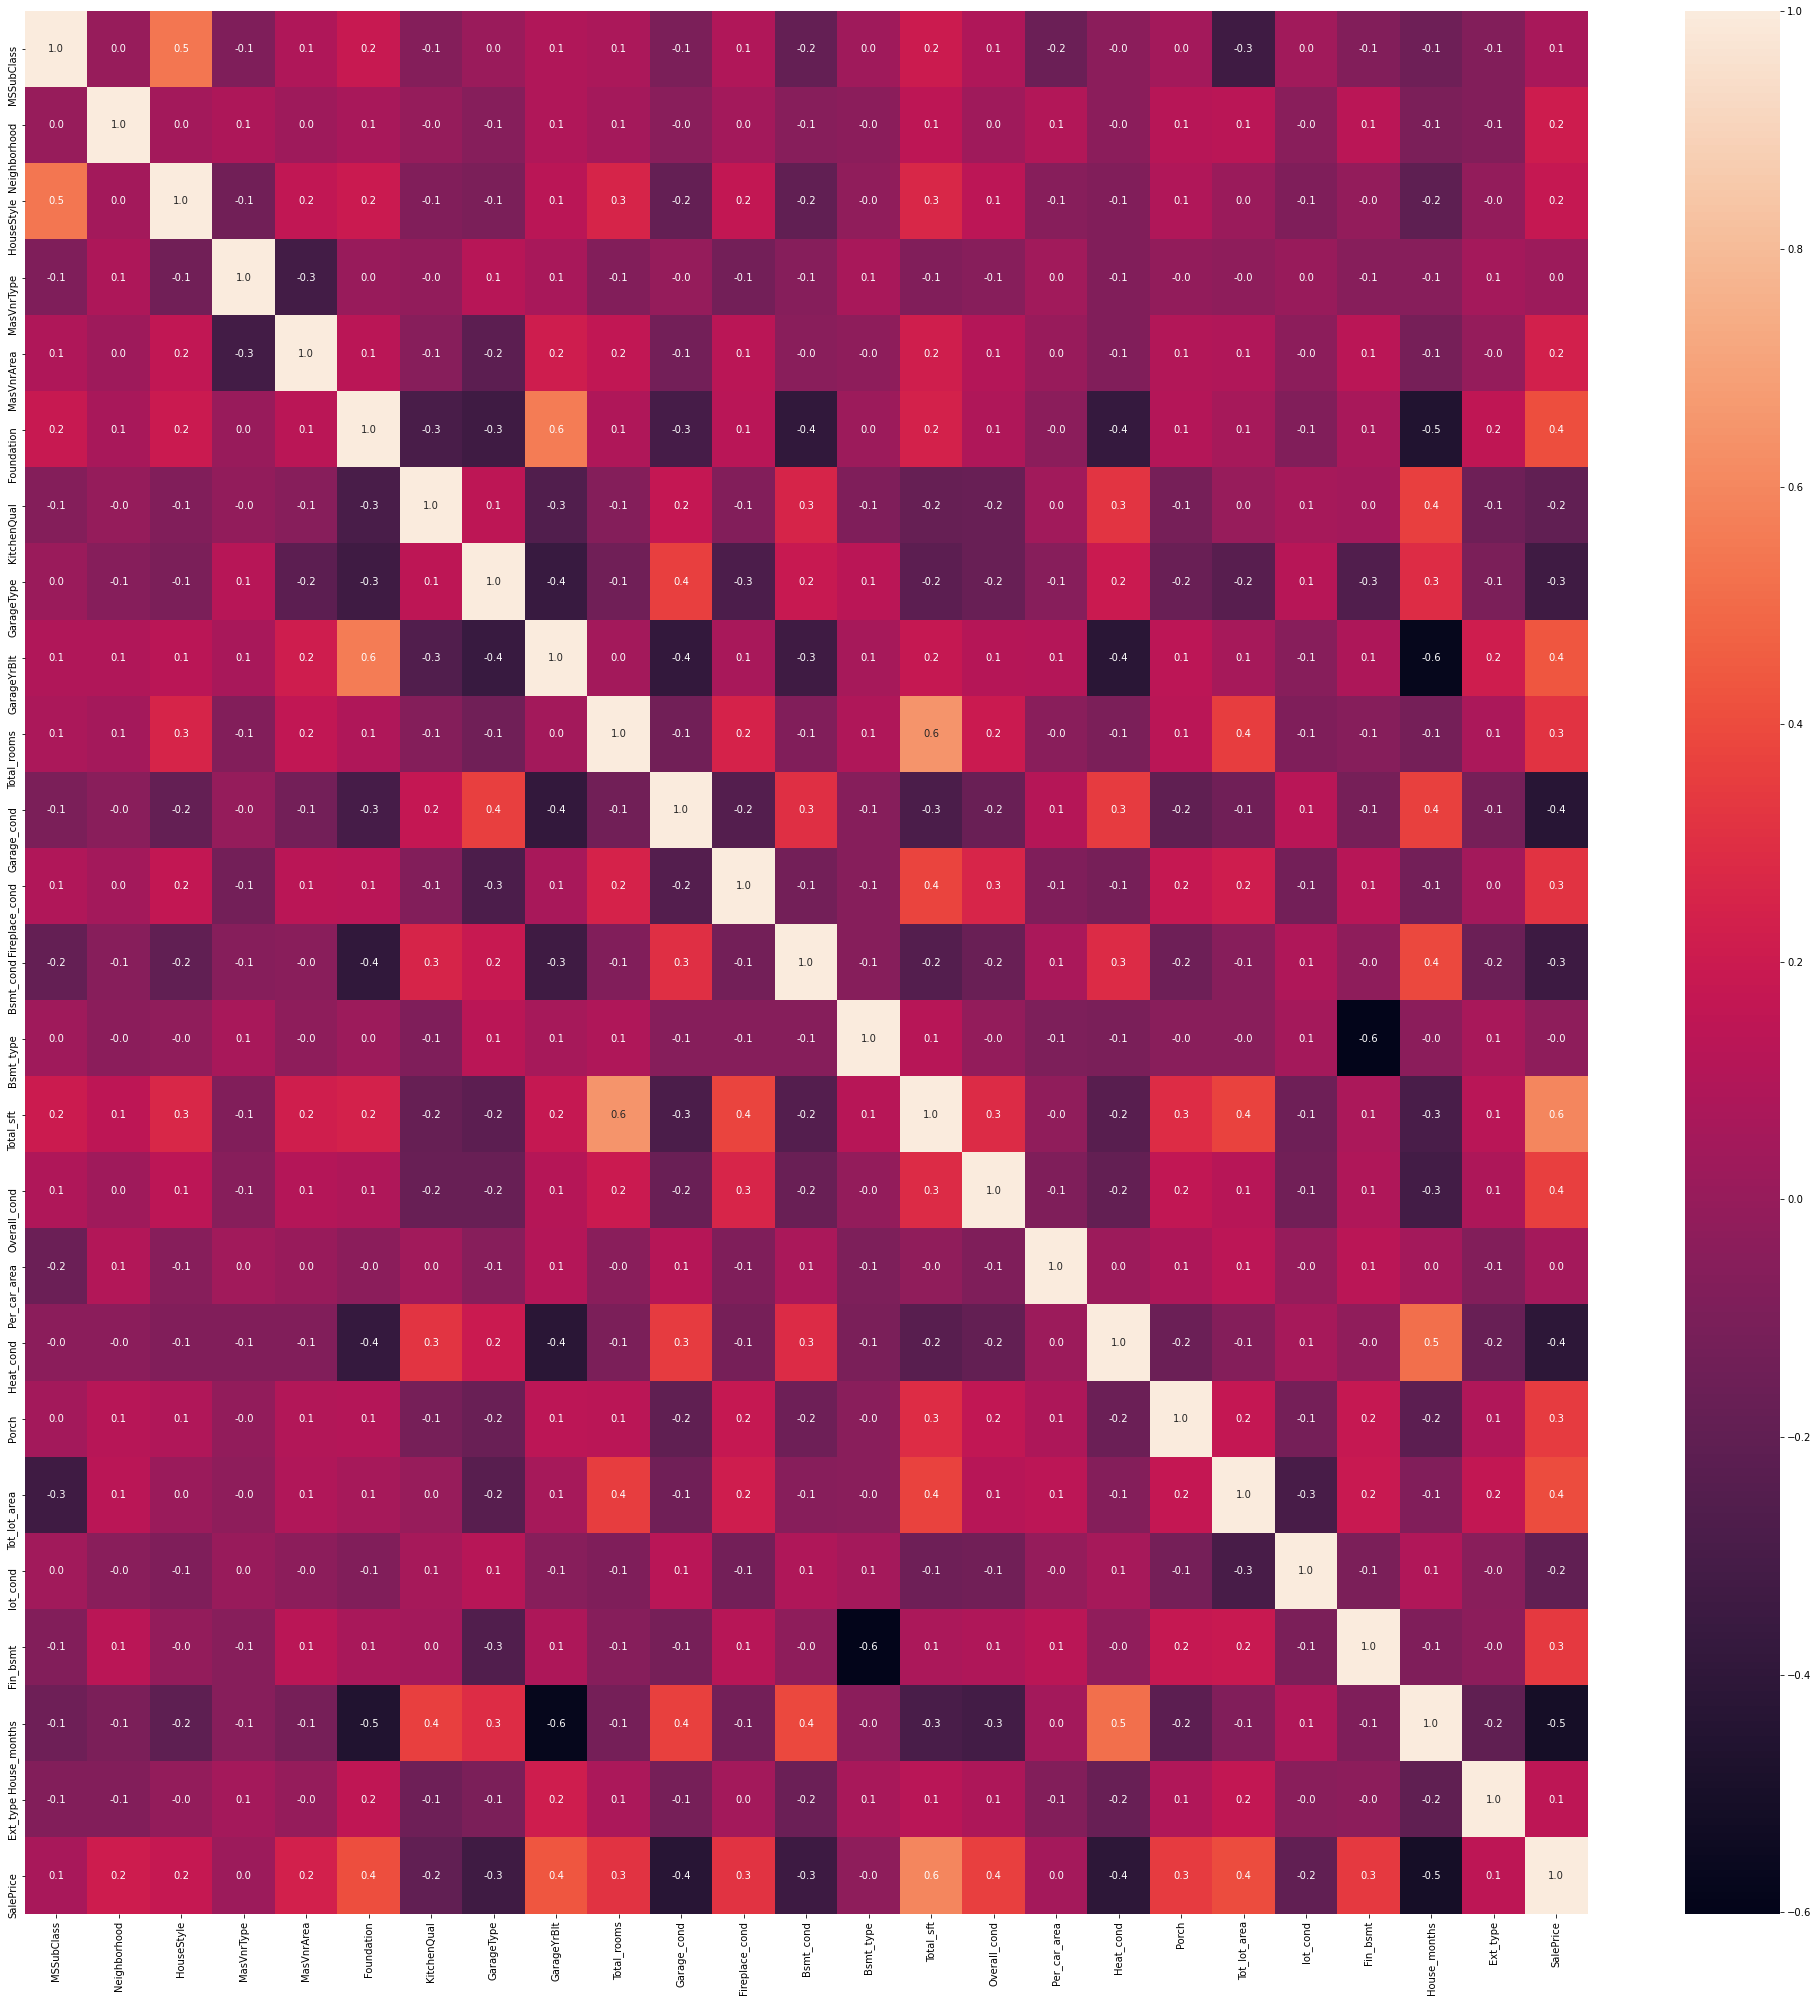

In [173]:
plt.rcParams['figure.figsize']=35,35
g = sns.heatmap(heat_df.corr(),annot=True, fmt = ".1f")

In [174]:
core = heat_df.corr()
core["SalePrice"].sort_values(ascending=False)

SalePrice         1.000000
Total_sft         0.597713
GarageYrBlt       0.433536
Foundation        0.406639
Tot_lot_area      0.404789
Overall_cond      0.357322
Porch             0.344433
Fin_bsmt          0.341670
Fireplace_cond    0.317717
Total_rooms       0.314193
MasVnrArea        0.234464
Neighborhood      0.210851
HouseStyle        0.180163
Ext_type          0.145217
MSSubClass        0.062669
Per_car_area      0.049765
MasVnrType        0.018216
Bsmt_type        -0.030962
KitchenQual      -0.194846
lot_cond         -0.197879
GarageType       -0.337403
Bsmt_cond        -0.340292
Heat_cond        -0.409854
Garage_cond      -0.431404
House_months     -0.508976
Name: SalePrice, dtype: float64

In [175]:
test1 = ['lot_cond', 'Total_sft', 'Total_rooms', 'Tot_lot_area',
       'Porch', 'Overall_cond', 'Neighborhood',
       'MasVnrArea', 'KitchenQual', 'House_months',
       'Heat_cond', 'Garage_cond', 'GarageYrBlt', 'GarageType', 'Foundation',
       'Fireplace_cond', 'Fin_bsmt', 'Bsmt_cond']

In [176]:
df = df[new_key_lst]

In [177]:
df.shape

(2919, 14)

### Normalization

In [178]:
scaler = MinMaxScaler()
norm_df = scaler.fit_transform(df)

### Standardization

In [179]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.fit_transform(df)

In [180]:
new_train = df[:1460]
new_test = df[1460:]

In [181]:
x_tr, x_te, y_tr, y_te = train_test_split(new_train,y,test_size=0.2,random_state=0)

### Random Forest 

In [182]:
rfreg = RandomForestRegressor(random_state = 1,n_estimators=200)
rfreg.fit(x_tr, y_tr)
rf_pred = rfreg.predict(x_te)
rmse = math.sqrt(mean_squared_error(np.log(y_te), np.log(rf_pred)))
rmse

0.17430186116709193

### Gradient Boosting

In [183]:
gbreg = GradientBoostingRegressor(random_state=0)
gbreg.fit(x_tr, y_tr)
gb_pred = gbreg.predict(x_te)
rmse = math.sqrt(mean_squared_error(np.log(y_te), np.log(gb_pred)))
rmse

0.1699525167932793

In [122]:
rfpred = rfreg.predict(new_test)

In [123]:
gbpred = gbreg.predict(new_test)

In [124]:
result = pd.DataFrame({'rf' : rfpred,'gb':gbpred}, columns=['rf','gb'])

In [125]:
result

,rf,gb
0,119821.665000,127124.163032
1,162412.250000,168131.786664
2,201689.500000,199972.151921
3,186546.250000,190703.982643
4,167856.775000,176810.551276
...,...,...
1454,90533.480000,76146.788256
1455,101142.006667,90243.176260
1456,152425.195000,207124.428514
1457,104989.150000,116788.286240


In [126]:
final_lst = []
for i in range(len(result)):
    val = math.exp((math.log(result['rf'][i]) + (math.log(result['gb'][i]))) / 2 )
    final_lst.append(val)
    
result['Final'] = final_lst

y3 = exp(  (log(y1) + log(y2)) / 2 )

In [127]:
result

,rf,gb,Final
0,119821.665000,127124.163032,123418.916201
1,162412.250000,168131.786664,165247.274618
2,201689.500000,199972.151921,200828.990275
3,186546.250000,190703.982643,188613.660221
4,167856.775000,176810.551276,172275.502969
...,...,...,...
1454,90533.480000,76146.788256,83029.113759
1455,101142.006667,90243.176260,95537.301275
1456,152425.195000,207124.428514,177682.248426
1457,104989.150000,116788.286240,110731.670728


In [63]:
output_df = pd.DataFrame(data={'Id':test_df['Id'].tolist(),'SalePrice':result['Final']})

In [64]:
output_df.to_csv('Submission.csv',index=False)

In [65]:
output_df

,Id,SalePrice
0,1461,131308.822708
1,1462,171959.794867
2,1463,194912.298053
3,1464,194192.330824
4,1465,164767.508687
...,...,...
1454,2915,80932.207516
1455,2916,90047.517572
1456,2917,181625.497073
1457,2918,110355.007011
